In [1]:
import sys
from functools import reduce
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

%matplotlib inline
%config IPComplete.greedy=True

In [2]:
# Local libraries
sys.path.append('../')
from down.lib.automata import automata

In [3]:
def filter(n):
    assert n<=7
    assert n>=0

    arr = np.zeros(3)
    for i in range(2,-1,-1):
        pos_val = 2**(i)
        if n >= pos_val:
            arr[i]=1
            n-=pos_val
    return arr

def filters(rule_number):
    filters = []
    inc = "{0:b}".format(rule_number)[::-1]
    for i,v in enumerate(inc):
        if v=='1':
            filters.append(filter(i))
    return filters

def apply_filter(state, f):
    vf = np.vectorize(lambda x: 1 if x==f.sum() else 0)
    return vf(np.convolve(state, f, mode='same'))

def apply_filters(state, fs):
    res = np.array([apply_filter(state, f) for f in fs])
    res = np.sum(res,axis=0)
    return (res%2)

#### Run it 

In [4]:
def middle_init_state(n):
    state = np.zeros(n,dtype=int)
    state[n//2]=1
    return state

In [5]:
RULE_SET = 90
INIT = middle_init_state(256)

In [6]:
from scipy.stats import bernoulli

In [7]:
SAMPLES_PER_DENSITY = 100
DENSITIES = [.1*x for x in range(2,9)]
WIDTH = 61
GENERATIONS = 2*WIDTH
RULE_SET = 90

In [8]:
inits = []
for p in DENSITIES:
    for _ in range(SAMPLES_PER_DENSITY):
        arr = np.random.random_sample(WIDTH) > (1-p)
        inits.append(arr)

In [9]:
patterns = [automata.generate_1d(RULE_SET, init, GENERATIONS) for init in inits]

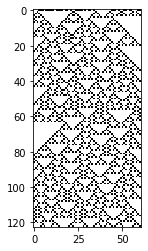

In [10]:
plt.imshow(1-patterns[400],cmap='gray')

In [11]:
import itertools

In [12]:
def patterns_to_x_y(pattern):
    ins = []
    outs = []
    for i in range(pattern.shape[0]-1):
        ins.append(pattern[i])
        outs.append(pattern[i+1])
    return ins, outs

def patterns_to_dataset(patterns):
    pairs = [patterns_to_x_y(pattern) for pattern in patterns]
    x_list, y_list = zip(*pairs)
    xx = list(itertools.chain(*x_list))
    yy = list(itertools.chain(*y_list))
    return xx, yy

In [13]:
x,y = patterns_to_dataset(patterns)
x = np.array(x, dtype=np.float)
y = np.array(y,dtype=np.float)

In [14]:
h = tf.data.Dataset.from_tensor_slices({'x':x, 'y':y})

In [15]:
class BasicModel(tf.keras.Model):
    def __init__(self, h1, width):
        super(BasicModel, self).__init__()
        self.h1 = tf.keras.layers.Dense(h1, activation='relu')
        self.h2 = tf.keras.layers.Dense(width, activation='relu')
        self.do1 = tf.keras.layers.Dropout(.2)
        
    def call(self, x):
        o1 = self.do1(self.h1(x))
        return self.h2(o1)

In [16]:
basic_model = BasicModel(125, WIDTH)

loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [37]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    tf.TensorSpec(shape=(None, None), dtype=tf.float64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):

    with tf.GradientTape() as tape:
        predictions = basic_model(inp)
        loss = loss_function(tar, predictions)
        
    gradients = tape.gradient(loss, basic_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, basic_model.trainable_variables))

    train_loss(loss)
    #train_accuracy(accuracy_function(tar_real, predictions))

In [31]:
#basic_model.compile(optimizer, loss_function)
#basic_model.fit(x,y,128, epochs=40)

In [32]:
#loss_function(np.array([1,3,4]),np.array([5,6,7])).numpy()

In [33]:
#basic_model(batch['x'])

In [40]:
epochs = 10
data = h.batch(128)
for epoch in range(epochs):
    
    train_loss.reset_states()
    for batch_num, batch in enumerate(data):
        train_step(batch['x'], batch['y'])
        if (batch_num%40)==0:
            s = 'Epoch {} Batch {} Loss {:.4f}'
            print(s.format(epoch + 1, batch_num, train_loss.result()))
          


Epoch 1 Batch 0 Loss 0.0003
Epoch 1 Batch 40 Loss 0.0001
Epoch 1 Batch 80 Loss 0.0001
Epoch 1 Batch 120 Loss 0.0001
Epoch 1 Batch 160 Loss 0.0001
Epoch 1 Batch 200 Loss 0.0002
Epoch 1 Batch 240 Loss 0.0002
Epoch 1 Batch 280 Loss 0.0002
Epoch 1 Batch 320 Loss 0.0003
Epoch 1 Batch 360 Loss 0.0003
Epoch 1 Batch 400 Loss 0.0003
Epoch 1 Batch 440 Loss 0.0003
Epoch 1 Batch 480 Loss 0.0003
Epoch 1 Batch 520 Loss 0.0003
Epoch 1 Batch 560 Loss 0.0003
Epoch 1 Batch 600 Loss 0.0003
Epoch 1 Batch 640 Loss 0.0003
Epoch 2 Batch 0 Loss 0.0003
Epoch 2 Batch 40 Loss 0.0001
Epoch 2 Batch 80 Loss 0.0001
Epoch 2 Batch 120 Loss 0.0001
Epoch 2 Batch 160 Loss 0.0001
Epoch 2 Batch 200 Loss 0.0002
Epoch 2 Batch 240 Loss 0.0002
Epoch 2 Batch 280 Loss 0.0002
Epoch 2 Batch 320 Loss 0.0003
Epoch 2 Batch 360 Loss 0.0003
Epoch 2 Batch 400 Loss 0.0003
Epoch 2 Batch 440 Loss 0.0003
Epoch 2 Batch 480 Loss 0.0003
Epoch 2 Batch 520 Loss 0.0003
Epoch 2 Batch 560 Loss 0.0003
Epoch 2 Batch 600 Loss 0.0003
Epoch 2 Batch 640 

In [ ]:
p = basic_model(x[:4,:])

In [ ]:
plt.scatter(p[0],y[0])

In [ ]:
plt.hist(p[0])